# Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ortools.linear_solver import pywraplp
import time
import logging

# Context

**Project Description**

WoodCraft Creations, a renowned woodcrafting company, is launching a new project to create
high-quality wooden tables for homes and offices. Their focus on sustainable sourcing and
timeless design ensures each table is both durable and stylish. The new table design requires the
following materials:
-  Wooden Planks:
    - `Tabletop`: 1 plank, providing a smooth, polished surface.
    - `Legs`: 4 planks, each supporting a leg.
    - `Beams`: 2 planks, connecting the legs for stability.
- Fasteners: `Screws` or nails to secure the legs, beams, and tabletop.
- Reinforcement: Metal `brackets` for added support at joints.
- Adhesive: Wood `glue` to reinforce joints and enhance stability.

WoodCraft Creations will develop production and ordering plans based on projected demand. This streamlined approach ensures efficient manufacturing and timely delivery of premium wooden tables.

In this project, WoodCraft Creations will use responsibly sourced materials, carefully selected to maintain environmental standards while delivering high-quality products. From cutting
and shaping wood planks to assembling and finishing the tables, the company ensures each step
of the production process meets its rigorous quality standards. With an experienced team and a
focus on bringing lasting value, this project aims to solidify WoodCraft Creations as a trusted
name in the furniture industry.
WoodCraft Creations has forecasted the demand for the new table over the next 16 days.
They anticipate introducing their tables within the next 5 days.

# PART I : Production Planning

## BOM
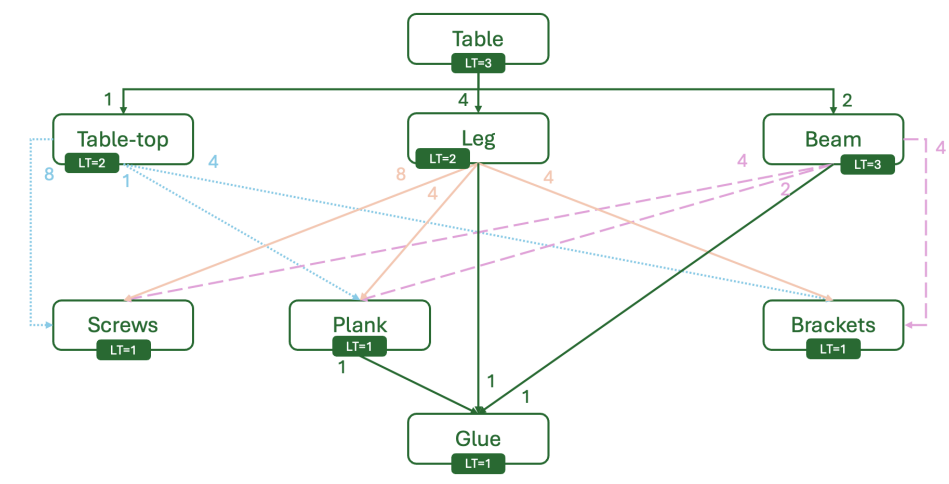

## Table 1: Demand of new Table in the upcoming 16 days
| Period   | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|----------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Demand   | 0  | 0  | 0  | 0  | 0  | 18 | 15 | 16 | 12 | 14 | 19 | 10 | 13 | 11 | 17 | 12 |

## Table 2: Information regarding production of the new table
| Product/material | Table | Tabletop | Leg | Beams | Screws | Planks | Brackets | Glue |
|------------------|-------|----------|-----|-------|--------|----------|--------|------|
| Lead-time        | 3     | 2        | 2   | 3     | 1      | 1        | 1      | 1    |
| Initial inventory| 0     | 20       | 100 | 70    | 50     | 100      | 50     | 100  |
| Production cost  | 100   | 100      | 100 | 100   | 100    | 100      | 100    | 100  |
| Inventory cost   | 20    | 10       | 10  | 10    | 5      | 5        | 5      | 5    |
| Setup cost       | 500   | 200      | 200 | 200   | 200    | 200      | 200    | 200  |


## Question 1

1. Determine the production and ordering plans for the table and its sub-materials. Solve
the optimal integrated model and also utilize the decomposition approach. Describe the
results, highlighting the differences.

From now on, continue with the optimal method and **retain the input of each question for
the subsequent ones.**

### Setting up data and the optimization function

In [3]:
def opt_production_plan(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # constraints
  m.Add(obj >= sum(
      sum(production[product]) * data.production_cost[product] +
      sum(setup[product]) * data.setup_cost[product] + 
      sum(inventory[product][:-1] * data.inventory_cost[product])
        for product in range(len(data.demands))))
  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

In [1]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

### Using integrated model to find Optimum

In [4]:
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:18:59,700 - DEBUG - Solver created.
2024-06-09 14:18:59,703 - DEBUG - Variables created.
2024-06-09 14:18:59,713 - DEBUG - Objective function added.
2024-06-09 14:18:59,727 - DEBUG - All constraints added.
2024-06-09 14:18:59,728 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:12,730 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:19:12,746 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,-0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,110.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1073.0,2200.0,0.0,0.0,424.0,2120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,489.0,935.0,0.0,0.0,212.0,901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,756.0,1100.0,0.0,0.0,424.0,1060.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,550.0,1108.0,220.0,0.0,212.0,1007.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1699796 . Run time is :  13.183247327804565


### Using Decomposition approach to observe
#### MPS

In [5]:
class data_generator_MPS():

  def __init__(self):

    self.demands = [[0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0]
    self.inventory_cost = [20] * len(self.demands)
    self.setup_cost = [500] * len(self.demands)

start_time = time.time()
data = data_generator_MPS()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:19:33,196 - DEBUG - Solver created.
2024-06-09 14:19:33,202 - DEBUG - Variables created.
2024-06-09 14:19:33,204 - DEBUG - Objective function added.
2024-06-09 14:19:33,213 - DEBUG - All constraints added.
2024-06-09 14:19:33,213 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:33,276 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:19:33,278 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,0.0,33.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,0.0,10.0,0.0,11.0,0.0,12.0,0.0


objective is :  19900 . Run time is :  0.10809922218322754


#### MRP
##### table top

In [6]:
class data_generator_MRP_tabelT():

  def __init__(self):

    self.demands = [[0, 0, 33, 0, 28, 0, 14, 29, 0, 24, 0, 29, 0, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    
    self.lead_time = [2]

    self.first_inventory = [20]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_tabelT()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

print('Table top obj fct: ')
run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:19:36,571 - DEBUG - Solver created.
2024-06-09 14:19:36,576 - DEBUG - Variables created.
2024-06-09 14:19:36,581 - DEBUG - Objective function added.
2024-06-09 14:19:36,586 - DEBUG - All constraints added.
2024-06-09 14:19:36,587 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:36,600 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:19:36,606 - DEBUG - Optimal solution found.


Table top obj fct: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,13.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,-0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  15300 . Run time is :  0.055376291275024414


##### Leg

In [7]:
class data_generator_MRP_leg():

  def __init__(self):

    self.demands = [[0.0, 0.0, 132.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0]
]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    
    self.lead_time = [2]



    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_leg()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:19:42,188 - DEBUG - Solver created.
2024-06-09 14:19:42,191 - DEBUG - Variables created.
2024-06-09 14:19:42,193 - DEBUG - Objective function added.
2024-06-09 14:19:42,196 - DEBUG - All constraints added.
2024-06-09 14:19:42,198 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:42,202 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:19:42,204 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,32.0,0.0,112.0,0.0,56.0,116.0,0.0,96.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  56000 . Run time is :  0.03440499305725098


##### Beams

In [8]:
class data_generator_MRP_beam():

  def __init__(self):

    self.demands = [[0.0, 0.0, 66.0, 0.0, 56.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.first_inventory = [70]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_beam()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:19:49,043 - DEBUG - Solver created.
2024-06-09 14:19:49,045 - DEBUG - Variables created.
2024-06-09 14:19:49,048 - DEBUG - Objective function added.
2024-06-09 14:19:49,048 - DEBUG - All constraints added.
2024-06-09 14:19:49,048 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:49,057 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:19:49,058 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,52.0,0.0,28.0,58.0,0.0,48.0,-0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,70.0,70.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  26880 . Run time is :  0.023196697235107422


##### Screws

In [9]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 8 for num in list1]
list2_multiplied = [num * 8 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for screws will be : {combined_list}')

The demand for screws will be : [360.0, 208.0, 1120.0, 112.0, 792.0, 1160.0, 192.0, 960.0, 232.0, 1160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
class data_generator_MRP_screws():

  def __init__(self):

    self.demands = [[360, 208, 1120, 112, 792, 1160, 192, 960, 232, 1160, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_screws()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:19:55,515 - DEBUG - Solver created.
2024-06-09 14:19:55,519 - DEBUG - Variables created.
2024-06-09 14:19:55,519 - DEBUG - Objective function added.
2024-06-09 14:19:55,522 - DEBUG - All constraints added.
2024-06-09 14:19:55,522 - DEBUG - Objective function set to minimize.
2024-06-09 14:19:55,522 - DEBUG - Solving the model, solver status: 2
2024-06-09 14:19:55,528 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">We observe that **The problem does not have an optimal solution.** Because screws will need to start at -1 in order to be ready for the production at day 1.</span>

##### Plank

In [12]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 1 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 2 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for planks will be : {combined_list}')

The demand for planks will be : [141.0, 104.0, 476.0, 56.0, 354.0, 493.0, 96.0, 408.0, 116.0, 493.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[141, 104, 476, 56, 354, 493, 96, 408, 116, 493, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:20:08,600 - DEBUG - Solver created.
2024-06-09 14:20:08,603 - DEBUG - Variables created.
2024-06-09 14:20:08,605 - DEBUG - Objective function added.
2024-06-09 14:20:08,608 - DEBUG - All constraints added.
2024-06-09 14:20:08,608 - DEBUG - Objective function set to minimize.
2024-06-09 14:20:08,611 - DEBUG - Solving the model, solver status: 2
2024-06-09 14:20:08,611 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">We observe the same, as to satisfy the demand for `table-top`, `beam` and `leg` the production for plank should also start at -1 day like for `screws`</span>

##### Brackets

In [14]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 4 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for brackets will be : {combined_list}')

The demand for brackets will be : [180.0, 208.0, 560.0, 112.0, 512.0, 580.0, 192.0, 480.0, 232.0, 580.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
class data_generator_MRP_brackets():

  def __init__(self):

    self.demands = [[180, 208, 560, 112, 512, 580, 192, 480, 232, 580, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:20:24,542 - DEBUG - Solver created.
2024-06-09 14:20:24,544 - DEBUG - Variables created.
2024-06-09 14:20:24,546 - DEBUG - Objective function added.
2024-06-09 14:20:24,547 - DEBUG - All constraints added.
2024-06-09 14:20:24,547 - DEBUG - Objective function set to minimize.
2024-06-09 14:20:24,552 - DEBUG - Solving the model, solver status: 2
2024-06-09 14:20:24,552 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">same problem</span>

##### Glue

In [16]:
# demand for glue for each leg, plank and beams
list1 = [141.0, 104.0, 476.0, 56.0, 354.0, 493.0, 96.0, 408.0, 116.0, 493.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 1 for num in list1]
list2_multiplied = [num * 1 for num in list2]
list3_multiplied = [num * 1 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for glue will be : {combined_list}')

The demand for glue will be : [173.0, 156.0, 588.0, 84.0, 468.0, 609.0, 144.0, 504.0, 174.0, 609.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[173.0, 156.0, 588.0, 84.0, 468.0, 609.0, 144.0, 504.0, 174.0, 609.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:20:31,321 - DEBUG - Solver created.
2024-06-09 14:20:31,325 - DEBUG - Variables created.
2024-06-09 14:20:31,329 - DEBUG - Objective function added.
2024-06-09 14:20:31,330 - DEBUG - All constraints added.
2024-06-09 14:20:31,333 - DEBUG - Objective function set to minimize.
2024-06-09 14:20:31,335 - DEBUG - Solving the model, solver status: 2
2024-06-09 14:20:31,336 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">
same problem, one solution could be to have more intial inventory in order to satisfy the demand for our product.

The integrated model and the decomposition approach to production planning handle the synchronization of production processes differently, which leads to discrepancies in their results, particularly regarding feasibility and efficiency.

**Integrated Model Approach:**
In the integrated model, the entire production process—right from raw materials to final product assembly—is considered as a single cohesive system. This model effectively coordinates all the sub-processes, ensuring that the timing of raw material acquisition, component production, and final assembly is synchronized across all stages. The solver used in the integrated model calculates the optimal production start times for each component, ensuring that all parts are available precisely when needed for assembly, despite the lead times. This is why the integrated model output seems feasible and presents a coherent production plan.

**Decomposition Approach:**
On the other hand, the decomposition approach breaks down the overall production process into smaller, independent units, each optimized separately. While this approach can simplify calculations and potentially increase focus on specific areas or units, it leads to a significant challenge: it does not inherently account for the interdependencies between different production stages. For instance, when you optimize sub-components like screws or planks separately, the model does not account for their necessary synchronization with the production of other parts like table tops or legs. As such, the decomposition model shows that production needs to start before day 1 to meet the demand by the given lead times, a situation that's obviously not feasible.

In essence, the decomposition approach highlights a critical flaw when it comes to the timing of each sub-component's production, suggesting the initiation of production activities before actual start capability (before day 1). This points out a non-feasible solution under actual production constraints and underscores the importance of the integrated model in handling complex, multi-stage production processes where timing synchronization is crucial. The integrated model, by considering all elements of the production chain simultaneously, ensures that all parts are produced and assembled in the right sequence to meet final product delivery dates effectively.
</span>

## Question 2

Take a closer look at the inventories among materials and describe why they are behaving
in this way.


<span style="color: orange">I do not observe antything abnormal, inventory naturally decreases as more items are produced which makes sense</span>

## Question 3
The company has decided to also sell the beams they produce to other companies. In the
table below, you can find the forecasted external demand for beams. 

Table 3: External demand for the beams:

| Period |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|--------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Demand |  0 |  0 |  0 |  0 |  0 |  5 |  7 |  4 |  6 |  7 |  3 |  6 |  5 |  4 |  7 |  6 |


What are the new production plans? Are they different from the ones produced before? Explain.

In [19]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:22:05,303 - DEBUG - Solver created.
2024-06-09 14:22:05,307 - DEBUG - Variables created.
2024-06-09 14:22:05,316 - DEBUG - Objective function added.
2024-06-09 14:22:05,335 - DEBUG - All constraints added.
2024-06-09 14:22:05,337 - DEBUG - Objective function set to minimize.


2024-06-09 14:22:20,563 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:22:20,563 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,-0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,-0.0,53.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,-0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,132.0,0.0,0.0,-0.0,113.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,17.0,10.0,6.0,0.0,0.0,28.0,22.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1161.0,2200.0,0.0,-0.0,452.0,2244.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,533.0,935.0,0.0,-0.0,226.0,963.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,844.0,1100.0,0.0,-0.0,452.0,1184.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,594.0,1130.0,220.0,-0.0,226.0,1076.0,243.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1785186 . Run time is :  15.280644655227661


<span style="color: orange">Well of course it is going to be different as we now have more demand for `beams` which needs `screws`, `planks`, `brackets` and `glue`, so the production for those components is of course going to increase..
The overall cost is also logically going to be higher as more production means higher costs. </span>

## Question 4

Now assume that the production cost varies among products as described in Table 4.

| Product/material | Table | Table-top | Leg | Beam | Screws | Plank | Brackets | Glue |
|------------------|-------|-----------|-----|------|--------|-------|----------|------|
| Demand           | 100   | 30        | 40  | 70   | 40     | 60    | 80       | 30   |


In [22]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100, 30, 40, 70, 40, 60, 80, 30]
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:28:06,844 - DEBUG - Solver created.
2024-06-09 14:28:06,845 - DEBUG - Variables created.
2024-06-09 14:28:06,855 - DEBUG - Objective function added.
2024-06-09 14:28:06,872 - DEBUG - All constraints added.
2024-06-09 14:28:06,872 - DEBUG - Objective function set to minimize.
2024-06-09 14:28:17,115 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:28:17,119 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,0.0,212.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,132.0,-0.0,0.0,0.0,113.0,31.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,17.0,10.0,6.0,0.0,0.0,28.0,22.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1161.0,2200.0,0.0,0.0,452.0,2244.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,533.0,935.0,0.0,0.0,226.0,963.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,844.0,1100.0,0.0,0.0,452.0,1184.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,594.0,1130.0,220.0,0.0,226.0,1076.0,243.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


objective is :  914606 . Run time is :  10.297384262084961


<span style="color: orange">exactly the same production plan, just cost decrease a whole lot..
The production plans for question 1 and question 4 are identical because the demand patterns, lead times, and optimization objectives remained unchanged in both scenarios. Despite varying production costs in question 4, the consistency in initial inventory levels, setup costs, and the need to meet demand within specific timeframes drove the same scheduling outcomes. The optimization model's constraints and logic, focused on minimizing total costs and ensuring timely production, led to the same production plan for both questions.
**However, we observe logically that cost decreases as the production costs decreases as well as per the new data which makes sense.**</span>

## Question 5

WoodCraft Creations usually used the stations of the new table during high-demand periods of another popular product. Because of that, the production cost in that period, for these stations which are related to Table assembly, leg, beams, and  tabletop stations, becomes 2 times more than usual. This period starts from day 5 to the end of day 9. The production cost will be as follows:


| Period      | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|-------------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Table       | 100| 100| 100| 100| 200| 200| 200| 200| 200| 100| 100| 100| 100| 100| 100| 100|
| Table-top   | 30 | 30 | 30 | 30 | 60 | 60 | 60 | 60 | 60 | 30 | 30 | 30 | 30 | 30 | 30 | 30 |
| Leg         | 40 | 40 | 40 | 40 | 80 | 80 | 80 | 80 | 80 | 40 | 40 | 40 | 40 | 40 | 40 | 40 |
| Beams       | 70 | 70 | 70 | 70 | 140| 140| 140| 140| 140| 70 | 70 | 70 | 70 | 70 | 70 | 70 |
| Screws      | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 |
| Plank       | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 |
| Brackets    | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 |
| Glue        | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 |

How does the production plans and the different components of the costs change based
on this new information?


In [23]:
def opt_production_plan_2(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # Objective function setup
  objective_terms = []
  for product in range(len(data.demands)):
      for day in range(len(data.days)):
          term = production[product][day] * data.production_cost[product][day] \
              + setup[product][day] * data.setup_cost[product] \
              + inventory[product][day] * data.inventory_cost[product]
          objective_terms.append(term)

  m.Add(obj >= sum(objective_terms))

  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

In [24]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]
    
    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)
            
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_2(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:29:04,430 - DEBUG - Solver created.
2024-06-09 14:29:04,439 - DEBUG - Variables created.
2024-06-09 14:29:04,443 - DEBUG - Objective function added.
2024-06-09 14:29:04,462 - DEBUG - All constraints added.
2024-06-09 14:29:04,462 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-09 14:29:05,306 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:29:05,306 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,-0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,0.0,60.0,56.0,50.0,43.0,40.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,0.0,0.0,1344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,0.0,0.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,0.0,0.0,764.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,0.0,0.0,585.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  926569 . Run time is :  0.8875315189361572


<span style="color: orange">
The cost is still lower than when we had prod cost at 100 for all products but is still higher than the one at the previous question, which is logical as the prod cost doubled at certain period.
Note that is is very close to the one of question 4
It also seems like it tries to avoid to produce during the high cost days.. which makes sense
</span>

## Question 6

How do the production plans change if the inventory cost of the table increases to 100 in
the last 5 days? Explain.

In [26]:
def opt_production_plan_3(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # Objective function setup
  objective_terms = []
  for product in range(len(data.demands)):
      for day in range(len(data.days)):
          term = production[product][day] * data.production_cost[product][day] \
              + setup[product][day] * data.setup_cost[product] \
              + inventory[product][day] * data.inventory_cost[product][day]
          objective_terms.append(term)

  m.Add(obj >= sum(objective_terms))

  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)
            
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    # Initialize inventory costs with last 5 days adjusted for the table
    self.inventory_cost = [
        [20] * 16,
        [10] * 16,
        [10] * 16,
        [10] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16
    ]
    print(self.inventory_cost)
    for day in range(11, 16):  # Days 12 to 16 (0-indexed as 11 to 15)
      self.inventory_cost[0][day] = 100  # Correctly accessing the first product's cost array

    print(self.inventory_cost)
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:51:33,573 - DEBUG - Solver created.
2024-06-09 14:51:33,575 - DEBUG - Variables created.
2024-06-09 14:51:33,578 - DEBUG - Objective function added.
2024-06-09 14:51:33,601 - DEBUG - All constraints added.
2024-06-09 14:51:33,603 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-09 14:51:34,327 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:51:34,327 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,-0.0,-0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,-0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,-0.0,0.0,116.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,-0.0,0.0,1344.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,-0.0,0.0,585.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,-0.0,0.0,764.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,-0.0,-0.0,585.0,162.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  929369 . Run time is :  0.772789716720581


<span style="color: orange">Compare to the production plan in question one we observe that the cost slightly increase which is normal as the inventory cost increases
We also naturally observe that instead of producing 53 unit of `table`at day 9 (which will keep some in the inventory), it tries to produce just what is necessary for the high inventory cost days which makes sense</span>

## Question 7

Assuming now that the setup cost of the table increases from 500 to 10000, how do
the total cost and its components change? Describe the changes of each separately and
together in this interval ([500,10000]). Explain the changes in the production plans.

### setup cost of 10000

In [28]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [10000, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-09 14:53:25,280 - DEBUG - Solver created.
2024-06-09 14:53:25,290 - DEBUG - Variables created.
2024-06-09 14:53:25,299 - DEBUG - Objective function added.
2024-06-09 14:53:25,313 - DEBUG - All constraints added.
2024-06-09 14:53:25,313 - DEBUG - Objective function set to minimize.
2024-06-09 14:53:25,651 - DEBUG - Solving the model, solver status: 0
2024-06-09 14:53:25,652 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,17.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,1.0,96.0,82.0,63.0,53.0,40.0,29.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,17.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,-0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,67.0,429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,29.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,428.0,1528.0,4290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,714.0,1823.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,248.0,1193.0,2145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,775.0,2105.0,429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1739151 . Run time is :  0.3846416473388672


<span style="color: orange">We clearly observe that the 2 first production of table does not change but starting from day 6 in produces all of what is needed, unlike in the first plan where it divided it into two days. This make sense as the setup increase to 10'000 producing all item in one go is more profitable than having multiple setup cost..</span>

<span style="color: orange">The overall cost is also way higher which makes sense because an increase of 95000 is quite a lot</span>

#### Varying setup cost between 500 and 10000
##### setup cost at from 500 to 1500

In [184]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [1500, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-07 10:27:35,220 - DEBUG - Solver created.
2024-06-07 10:27:35,228 - DEBUG - Variables created.
2024-06-07 10:27:35,238 - DEBUG - Objective function added.
2024-06-07 10:27:35,259 - DEBUG - All constraints added.
2024-06-07 10:27:35,259 - DEBUG - Objective function set to minimize.


2024-06-07 10:27:40,894 - DEBUG - Solving the model, solver status: 0
2024-06-07 10:27:40,909 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,-0.0,-0.0,-0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,-0.0,33.0,63.0,220.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,110.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1073.0,2200.0,0.0,0.0,424.0,2120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,489.0,935.0,0.0,0.0,212.0,901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,756.0,1100.0,0.0,0.0,424.0,1060.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,550.0,1108.0,220.0,-0.0,212.0,1007.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1704796 . Run time is :  5.7110724449157715


<span style="color: orange">Cost naturally increase as setup cost increase.</span>

##### setup cost to 2000 

In [185]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [2000, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-07 10:28:34,416 - DEBUG - Solver created.
2024-06-07 10:28:34,420 - DEBUG - Variables created.
2024-06-07 10:28:34,421 - DEBUG - Objective function added.
2024-06-07 10:28:34,431 - DEBUG - All constraints added.
2024-06-07 10:28:34,436 - DEBUG - Objective function set to minimize.
2024-06-07 10:28:37,566 - DEBUG - Solving the model, solver status: 0
2024-06-07 10:28:37,569 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,96.0,82.0,63.0,53.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1497.0,4320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,701.0,1836.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,1180.0,2160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,762.0,2115.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1707136 . Run time is :  3.1717400550842285


<span style="color: orange">Cost naturally increase as setup cost increase. The threshold for a change in the production plan seems to be around 2000 for setup cost where we observe that at day 5 it produces more at once</span>

##### increase setup cost to 5000

In [190]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [5000, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-07 10:29:43,741 - DEBUG - Solver created.
2024-06-07 10:29:43,744 - DEBUG - Variables created.
2024-06-07 10:29:43,755 - DEBUG - Objective function added.
2024-06-07 10:29:43,766 - DEBUG - All constraints added.
2024-06-07 10:29:43,769 - DEBUG - Objective function set to minimize.
2024-06-07 10:29:43,977 - DEBUG - Solving the model, solver status: 0
2024-06-07 10:29:43,977 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,17.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,1.0,96.0,82.0,63.0,53.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,17.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,68.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,29.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,428.0,1538.0,4280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,718.0,1819.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,248.0,1198.0,2140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,780.0,2101.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1719164 . Run time is :  0.25426697731018066


<span style="color: orange">Then we observe that interestingly around the 5000 threshold it changes very ligthly where day 4 produces 1 unit more which is weird, then it doesn't change unitl increasing it to 10000. Otherwise same pattern, as setup cost increase overall cost increases </span>

## Question 8

The process to produce each of the sub-materials in the BOM is as follows:

- Plank: Cutting station
- Leg: Shaping station - Drilling station
- Beam: Shaping station - Drilling station
- Top: Shaping station - Drilling station
- Table: Assembly station - Sanding station - Finishing station

The information regarding each station is given in Table 6. 

| Station    | Processing time (min) | Setup time (min) | Available stations | Efficiency |
|------------|-----------------------|------------------|--------------------|------------|
| Cutting    | 1                     | -                | 4                  | 80%        |
| Shaping    | 1.5                   | 30               | 2                  | 75%        |
| Drilling   | 0.9                   | 5                | 1                  | 90%        |
| Assembly   | 3                     | -                | 1                  | 95%        |
| Sanding    | 1.5                   | -                | 1                  | 95%        |
| Finishing  | 2                     | -                | 1                  | 98%        |


Each working day is 8 hours.

Solve the production plan again with the new information (both optimally and using the
decomposition approach) and compare the results with those obtained previously. Explain
the differences.


## Question 9

# Schedulling
In this second phase, we’re focusing on the assembly station, a critical part of our production
process. It handles various products, some from earlier stages and others newly added. Our
goal is to efficiently manage its 3 machines to ensure smooth operations and meet production
3 demands. To cope with the station’s heavy workload, we’ve extended daily working hours to
10, from 8 am to 6 pm.
The list of all the materials that need to be processed on the Assembly station is provided in
a file named data project.csv. For this part, if specific methods are not mentioned, please
create a mathematical model to answer the questions.
## Question 1
First, find a schedule that minimizes the maximum duration during which machines are
working. This enables WoodCraft Creations to accept more orders from outside. Explain the mathematical objective function you use for this purpose and provide a rationale
for your choice. Additionally, explore alternative methods for determining the optimal
schedule, if any exist. **Assume all tasks are available at the beginning of the planning
horizon**

In [2]:
data = pd.read_csv('data/data_project_1.csv')
data

,Product,Needed_Time(Hour),Needed_Time(Minute),Earliest_Available_Time(Day),Earliest_Available_Time(Hour),Earliest_Available_Time(Minute),Priority,Due_Time(Day),Due_Time(Hour),Due_Time(Minute)
0,1,2,45,Tuesday,16,45,1,Wednesday,10,30
1,2,1,45,Monday,15,45,3,Wednesday,12,0
2,3,2,45,Monday,17,45,4,Thursday,11,45
3,4,2,0,Monday,8,30,1,Wednesday,13,45
4,5,2,30,Monday,10,30,1,Tuesday,8,30
5,6,3,15,Tuesday,16,0,2,Thursday,17,30
6,7,1,30,Tuesday,16,30,3,Wednesday,13,30
7,8,1,15,Tuesday,17,45,1,Friday,9,45
8,9,3,0,Monday,13,30,2,Thursday,14,15
9,10,3,0,Monday,17,15,1,Wednesday,12,30


In [9]:
JOBS = {
    'A': {'release': 0, 'duration': 2*60 + 45, 'due': 24*60 + 10*60 + 30, 'weight': 1},
    'B': {'release': 0, 'duration': 1*60 + 45, 'due': 48*60 + 12*60, 'weight': 3},
    'C': {'release': 0, 'duration': 2*60 + 45, 'due': 72*60 + 11*60 + 45, 'weight': 4},
    'D': {'release': 0, 'duration': 2*60, 'due': 48*60 + 13*60 + 45, 'weight': 1},
    'E': {'release': 0, 'duration': 2*60 + 30, 'due': 24*60 + 8*60 + 30, 'weight': 1},
    'F': {'release': 0, 'duration': 3*60 + 15, 'due': 72*60 + 17*60 + 30, 'weight': 2},
    'G': {'release': 0, 'duration': 1*60 + 30, 'due': 24*60 + 13*60 + 30, 'weight': 3},
    'H': {'release': 0, 'duration': 1*60 + 15, 'due': 96*60 + 9*60 + 45, 'weight': 1},
    'I': {'release': 0, 'duration': 3*60, 'due': 72*60 + 14*60 + 15, 'weight': 2},
    'J': {'release': 0, 'duration': 3*60, 'due': 48*60 + 12*60 + 30, 'weight': 1},
    'K': {'release': 0, 'duration': 3*60 + 45, 'due': 72*60 + 13*60 + 30, 'weight': 1},
    'L': {'release': 0, 'duration': 1*60 + 15, 'due': 24*60 + 15*60, 'weight': 1},
    'M': {'release': 0, 'duration': 45, 'due': 24*60 + 16*60 + 45, 'weight': 1},
    'N': {'release': 0, 'duration': 2*60 + 15, 'due': 24*60 + 13*60 + 30, 'weight': 1},
    'O': {'release': 0, 'duration': 1*60, 'due': 15*60 + 45, 'weight': 3},
    'P': {'release': 0, 'duration': 2*60 + 45, 'due': 72*60 + 17*60, 'weight': 4},
    'Q': {'release': 0, 'duration': 2*60 + 30, 'due': 48*60 + 8*60 + 45, 'weight': 4},
}

MACHINES = ['A', 'B', 'C']


Explanation:

- release: This is the earliest available time converted to minutes. For instance, 16:45 on Tuesday is (16*60 + 45) minutes.
- duration: The needed time converted to minutes.
- due: The due time converted to minutes from the start of the week. For instance, Wednesday at 10:30 is (2460 + 1060 + 30) minutes since Monday 00:00.
- weight: This corresponds to the priority.
Each job is labeled from 'A' to 'Q', corresponding to the product numbers 1 to 17.

In [4]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()


def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

def milp(JOBS, MACHINES):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    #Big M
    BigM = sum([JOBS[j]['duration'] for j in JOBS.keys()])

    # decision variables
    completion_time = []
    for job_id in JOBS.keys():
        suffix = '_%s' % job_id
        completion_time.append(m.NumVar(0,BigM,'C' + suffix))


    # additional decision variables for use in the objecive
    makespan = m.NumVar(0, BigM, 'makespan')

    # for binary assignment of jobs to machines
    assignJob2Mch = []
    for job_id in JOBS.keys():
        assignJob2Mch_nested = []
        for mch in MACHINES:
            # suffix = '_%s_%s' % (job,m)
            suffix = '_%s' % job_id
            assignJob2Mch_nested.append(m.BoolVar('z' + suffix))
        assignJob2Mch.append(assignJob2Mch_nested)


    # for modeling disjunctive constraints
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        auxilaryVar_nested = []
        for job_k in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)


    # constraints
    for mach in range(len(MACHINES)):
        m.Add(sum(assignJob2Mch[j][mach]*JOBS[job_id]['duration'] for j,job_id in enumerate(JOBS.keys())) <= makespan)
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] <= makespan)
        m.Add(completion_time[j] >= JOBS[job_id]['duration'] + JOBS[job_id]['release'])
        m.Add(sum(assignJob2Mch[j][mach] for mach in range(len(MACHINES))) == 1)
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                for mch in range(len(MACHINES)):
                    m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + BigM*(auxilaryVar[j][k] + (1-assignJob2Mch[j][mch]) + (1-assignJob2Mch[k][mch])))
                    m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j] + BigM*((1 - auxilaryVar[j][k]) + (1-assignJob2Mch[j][mch]) + (1-assignJob2Mch[k][mch])))

    # objective function
    m.Minimize(makespan)

    status = m.Solve()
    # print(m.VerifySolution(0,True))

    if status == pywraplp.Solver.OPTIMAL:

        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            mm = [mach for mach in range(len(MACHINES)) if assignJob2Mch[j][mach].solution_value()==1]
            SCHEDULE[job_id] = {'machine': MACHINES[mm[0]],
                                'start': completion_time[j].solution_value() - JOBS[job_id]['duration'],
                                'finish': completion_time[j].solution_value() }
        print(SCHEDULE)
        print(m.Objective().Value())
        return SCHEDULE

    else:
        print('The problem does not have an optimal solution.')

{'Makespan': 780,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 17,
 'Fraction on Time': 1.0}

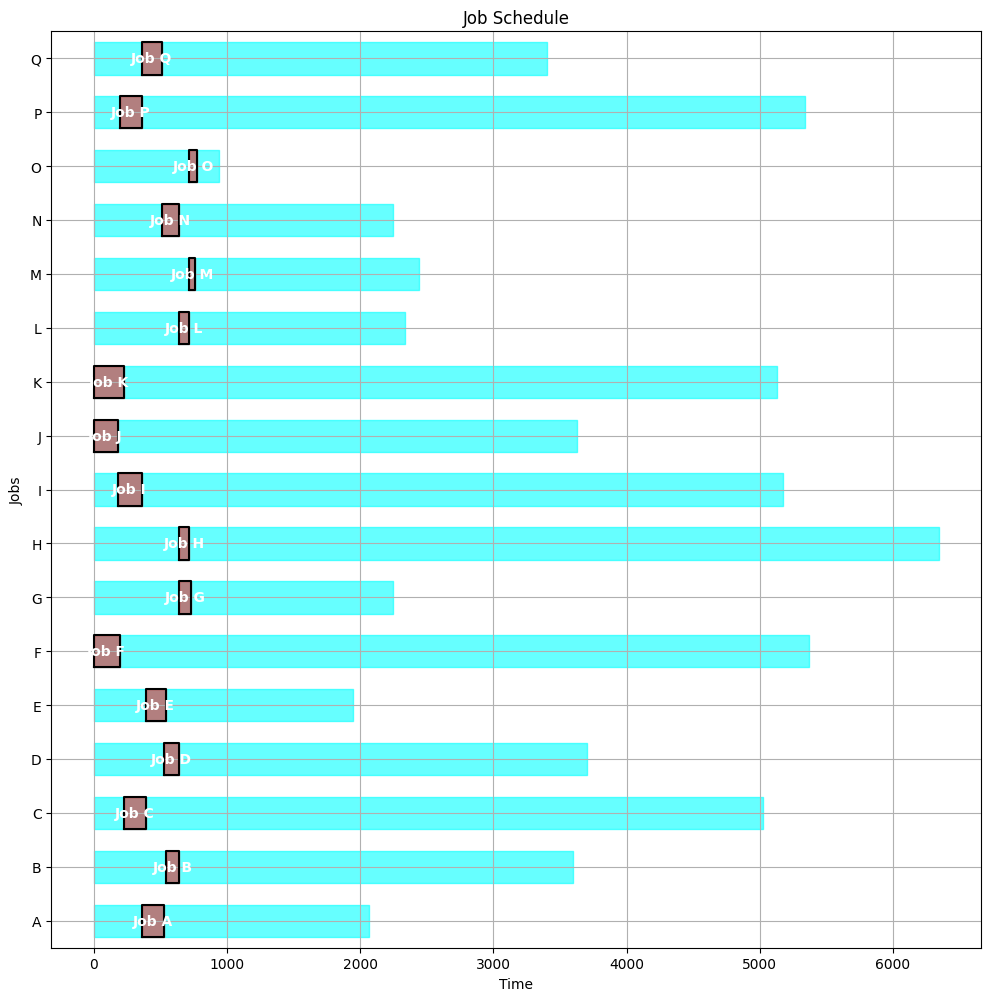

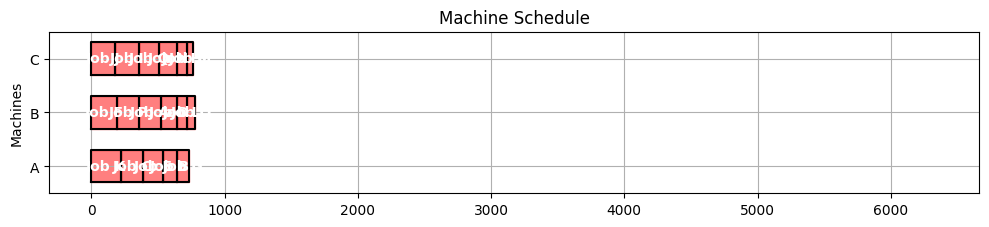

In [6]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}

    machine_finish = [0,0,0]
    for job in order:
        available_machine = machine_finish.index(min(machine_finish))
        start = max(JOBS[job]['release'], min(machine_finish))
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'machine': MACHINES[available_machine],'start': start, 'finish': finish}
        machine_finish[available_machine] = finish
    return SCHEDULE

### LPT

{'Makespan': 780,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 17,
 'Fraction on Time': 1.0}

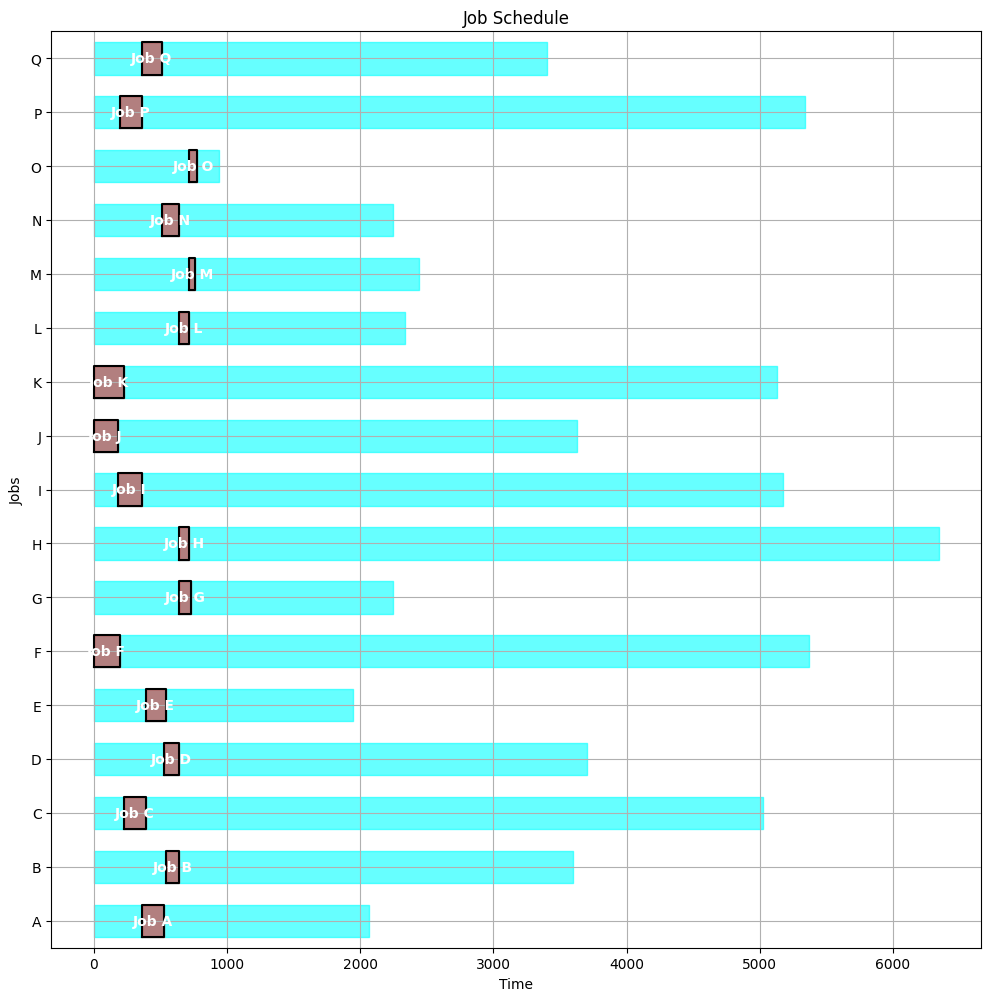

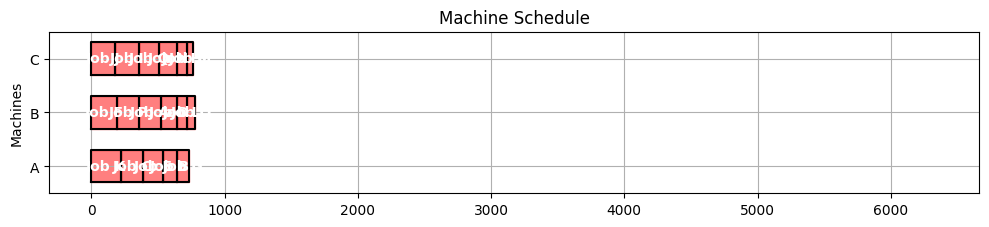

In [10]:
SCHEDULE = schedule(JOBS)
SCHEDULE

order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['duration'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### WSPT

['O', 'G', 'B', 'Q', 'P', 'C', 'M', 'L', 'H', 'I', 'F', 'D', 'N', 'E', 'A', 'J', 'K']
[0.006060606060606061, 0.02857142857142857, 0.024242424242424242, 0.008333333333333333, 0.006666666666666667, 0.010256410256410256, 0.03333333333333333, 0.013333333333333334, 0.011111111111111112, 0.005555555555555556, 0.0044444444444444444, 0.013333333333333334, 0.022222222222222223, 0.007407407407407408, 0.05, 0.024242424242424242, 0.02666666666666667]


{'Makespan': 825,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 17,
 'Fraction on Time': 1.0}

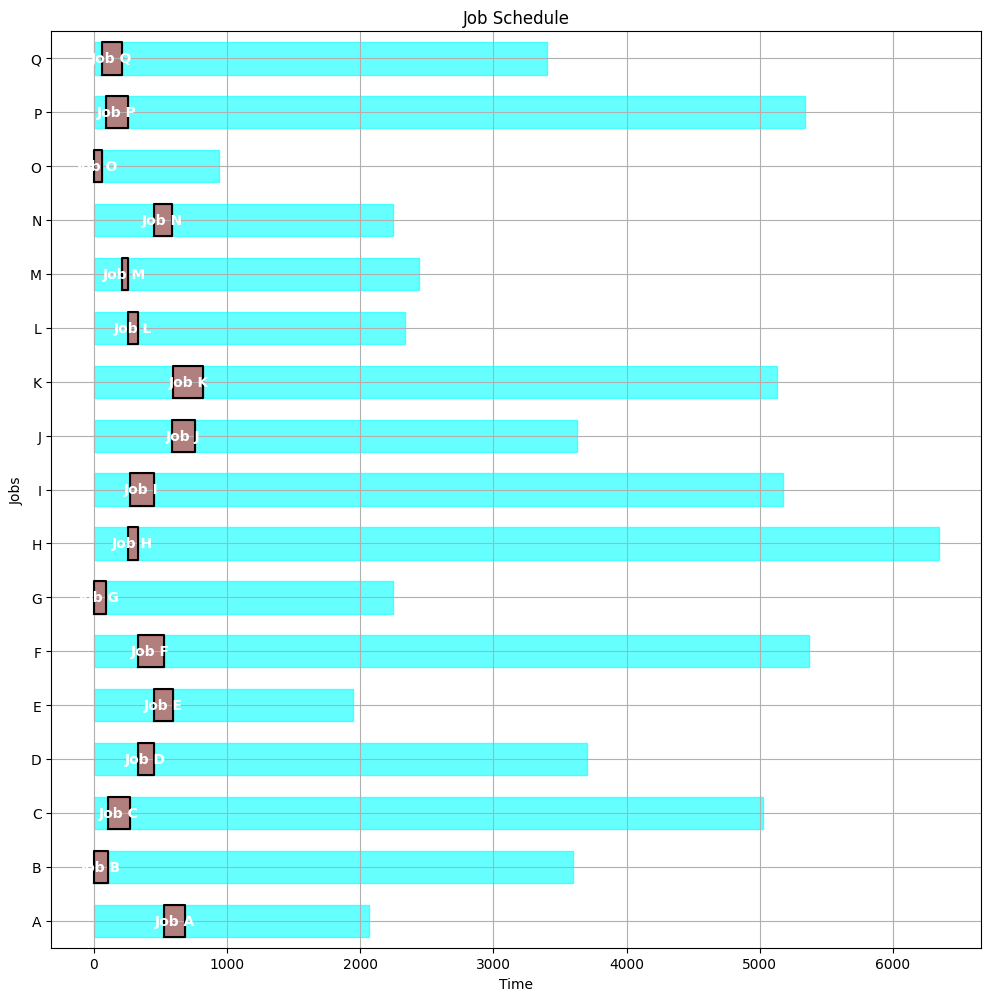

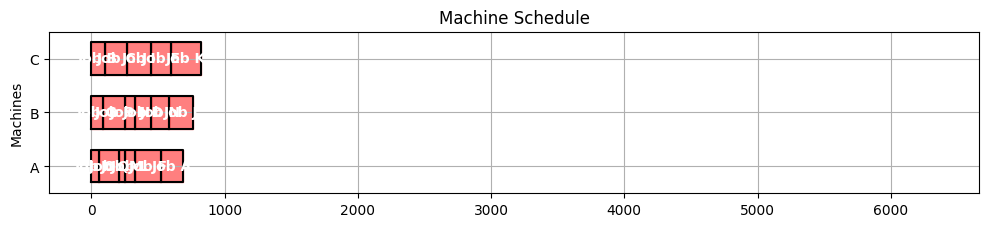

In [11]:
order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['weight']/JOBS[x]['duration'], x))
print(order)
print([JOBS[x]['weight']/JOBS[x]['duration'] for x in JOBS]) #it prints not in order
gantt(JOBS, schedule(JOBS,order)) 
kpi(JOBS, schedule(JOBS,order))

### SPT

['M', 'O', 'H', 'L', 'G', 'B', 'D', 'N', 'E', 'Q', 'A', 'C', 'P', 'I', 'J', 'F', 'K']


{'Makespan': 855,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 17,
 'Fraction on Time': 1.0}

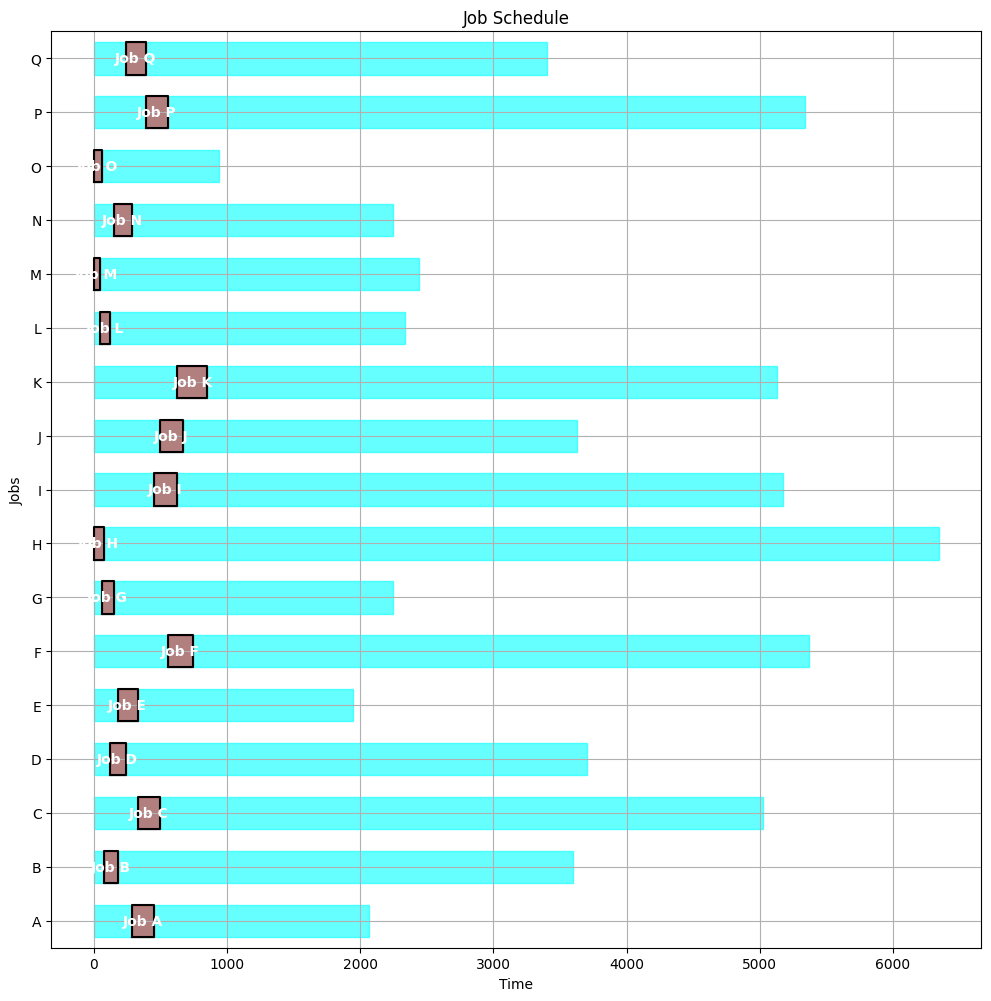

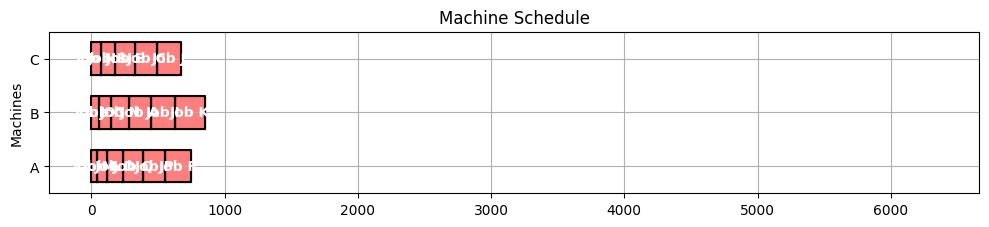

In [12]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['duration'], x))
print(order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### Flow time

In [13]:
def opt_schedule(JOBS):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[job_id]['release'] for job_id in JOBS.keys()]) + sum([JOBS[job_id]['duration'] for job_id in JOBS.keys()])


    # decision variables
    completion_time = []
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))

        auxilaryVar_nested=[]
        for job_k in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)


    # additional decision variables for use in the objecive

    # constraints
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] >= JOBS[job_id]['release'] + JOBS[job_id]['duration'])
        m.Add(completion_time[j] >= JOBS[job_id]['release'] + JOBS[job_id]['duration'])
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + tmax*auxilaryVar[j][k])
                m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j] + tmax*(1 - auxilaryVar[j][k]))

    # objective function
    m.Minimize(sum([completion_time[j] for j,job_id in enumerate(JOBS.keys())]))

    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:

        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        return SCHEDULE

    else:
        print('The problem does not have an optimal solution.')

SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

takes too much time to compute..

### EDD

In [ ]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['due'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

The MILP takes way to much times to runs, thus we'll focus on the LPT

Why ? 

because based on the course material, the Largest-Processing-Time-first (LPT) heuristic is recommended as the best heuristic method to minimize the duration in scheduling. This method sequences jobs to be processed on a resource in descending order of their processing times. It is particularly effective for minimizing the makespan on identical parallel machines by assigning each job to the machine with the least start time. This approach is illustrated and recommended for its effectiveness in achieving good scheduling performance in minimizing the total processing time Analytics in Operations Management, pages 168-176.

## Question 2
Now, consider that not all products are ready at the beginning of the scheduling horizon.
Assume the release times given in the CSV file and create a new schedule based on the
fact that jobs cannot be processed before their release time. Does anything change? How?
What is the effect? Describe the characteristics of the new schedule and justify the chosen
modeling approach.
From now on, keep the release time in your modeling:


{'Makespan': 1755,
 'Max Pastdue': 810,
 'Sum of Pastdue': 810,
 'Number Pastdue': 1,
 'Number on Time': 16,
 'Fraction on Time': 0.9411764705882353}

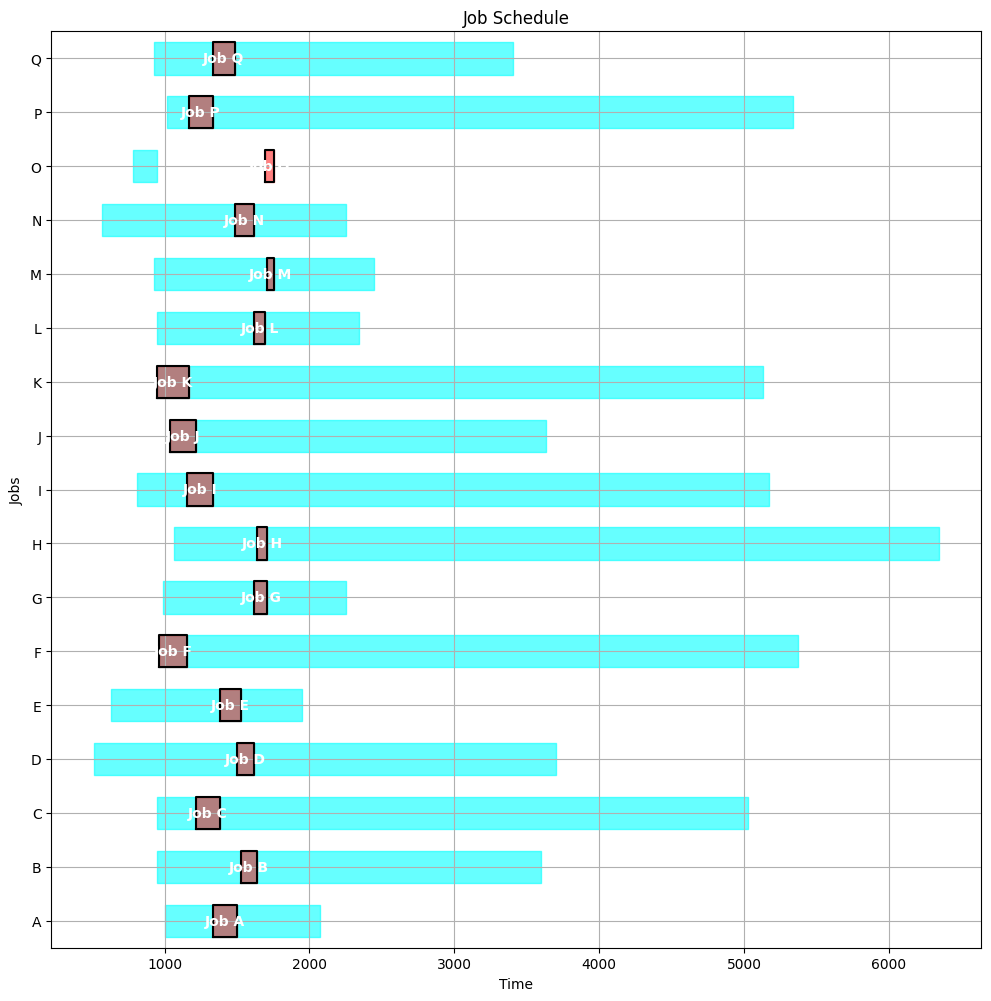

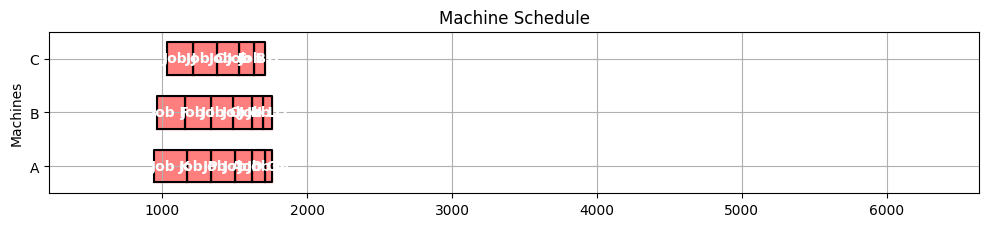

In [7]:
JOBS = {
    'A': {'release': 16*60 + 45, 'duration': 2*60 + 45, 'due': 24*60 + 10*60 + 30, 'weight': 1},
    'B': {'release': 15*60 + 45, 'duration': 1*60 + 45, 'due': 48*60 + 12*60, 'weight': 3},
    'C': {'release': 15*60 + 45, 'duration': 2*60 + 45, 'due': 72*60 + 11*60 + 45, 'weight': 4},
    'D': {'release': 8*60 + 30, 'duration': 2*60, 'due': 48*60 + 13*60 + 45, 'weight': 1},
    'E': {'release': 10*60 + 30, 'duration': 2*60 + 30, 'due': 24*60 + 8*60 + 30, 'weight': 1},
    'F': {'release': 16*60, 'duration': 3*60 + 15, 'due': 72*60 + 17*60 + 30, 'weight': 2},
    'G': {'release': 16*60 + 30, 'duration': 1*60 + 30, 'due': 24*60 + 13*60 + 30, 'weight': 3},
    'H': {'release': 17*60 + 45, 'duration': 1*60 + 15, 'due': 96*60 + 9*60 + 45, 'weight': 1},
    'I': {'release': 13*60 + 30, 'duration': 3*60, 'due': 72*60 + 14*60 + 15, 'weight': 2},
    'J': {'release': 17*60 + 15, 'duration': 3*60, 'due': 48*60 + 12*60 + 30, 'weight': 1},
    'K': {'release': 15*60 + 45, 'duration': 3*60 + 45, 'due': 72*60 + 13*60 + 30, 'weight': 1},
    'L': {'release': 15*60 + 45, 'duration': 1*60 + 15, 'due': 24*60 + 15*60, 'weight': 1},
    'M': {'release': 15*60 + 30, 'duration': 45, 'due': 24*60 + 16*60 + 45, 'weight': 1},
    'N': {'release': 9*60 + 30, 'duration': 2*60 + 15, 'due': 24*60 + 13*60 + 30, 'weight': 1},
    'O': {'release': 13*60, 'duration': 1*60, 'due': 15*60 + 45, 'weight': 3},
    'P': {'release': 17*60, 'duration': 2*60 + 45, 'due': 72*60 + 17*60, 'weight': 4},
    'Q': {'release': 15*60 + 30, 'duration': 2*60 + 30, 'due': 48*60 + 8*60 + 45, 'weight': 4},
}

MACHINES = ['A', 'B', 'C']

SCHEDULE = schedule(JOBS)
SCHEDULE

order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['duration'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))